# Integrales de camino como enfoque alternativo para la valuación de opciones financieras

In [1]:
# Importar las librerías
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ==========
# Parámteros
# ==========

# Taza libre de riesgo
r = 0.03
# Volatilidad por año
sigma = 0.3
# Factor por conveniencia
rhat = r - 0.5 * sigma**2
# Ventana 1 año
t = 1
# Número de intervalos de tiempo
N = 4
# Intervalo temporal
dt = t / N

In [3]:
# ===========================
# Propagador de Black-Scholes
# ===========================

def K_BS(xf):
    return np.exp(-r * t - ((xf + t * rhat)**2) / (2 * t * sigma**2)) / np.sqrt(2 * np.pi * t * sigma**2)

## Motecarlo uniforme

In [4]:
# =====================
# Definición de caminos
# =====================

# Muestras de rutas
Npath = 20000000
# Matriz x en donde almacenan las rutas:
# El primer índice etiqueta los puntos N y el segundo índice etiqueta las diferentes rutas
x = -4 * sigma + 8 * sigma * np.random.rand(N, Npath) 

# La contribución de cada segmento y de cada ruta a S_{BS} se calcula y se almacena en la variable `term1`. 
# La contribución del primer segmento, que comienza en x0 = 0, se calcula por separado y se almacena en el `term2`
term1 = np.sum((x[1:, :] - x[:-1, :] + dt * rhat)**2, axis=0)
term2 = (x[0, :] + dt * rhat)**2

# Calcular exponencial de la suma de las variables `term1` y `term2`
ExpSBS = np.exp(-(term1 + term2) / (2 * dt * sigma**2))

# ===========
# Histogramas
# ===========

# Crear histograma para la integral de camino
ix = np.round(x[-1, :] / (sigma / 5))
ixmin, ixmax = int(np.min(ix)), int(np.max(ix))
xx = np.arange(ixmin, ixmax + 1) * sigma / 5
PathIntegral = np.zeros(ixmax - ixmin + 1)

# Poblar PathIntegral
for k in range(Npath):
    ipos = int(ix[k]) - ixmin
    PathIntegral[ipos] += ExpSBS[k]

# Normalizar
i0 = (xx[1] - xx[0]) * np.sum(PathIntegral)
PathIntegral = np.exp(-r * t) * PathIntegral / i0

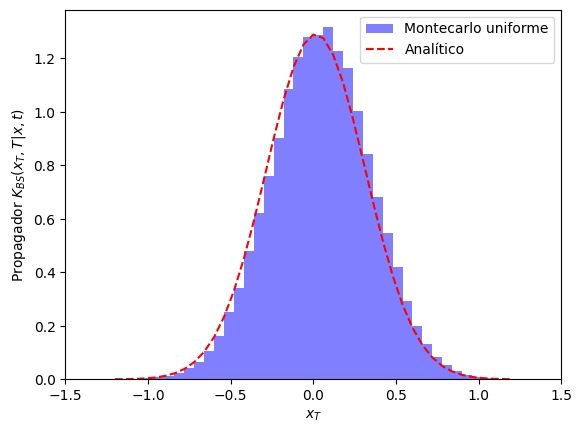

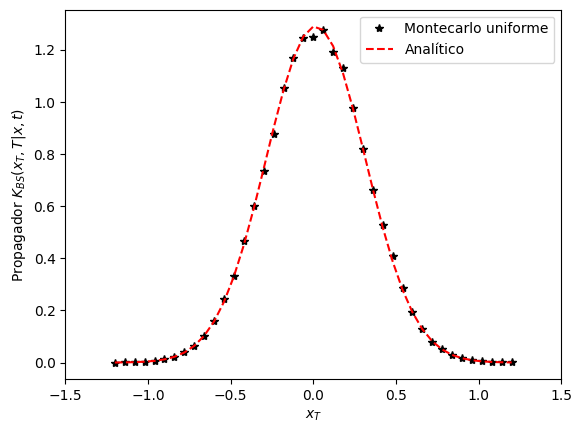

In [5]:
# =====================
# Gráficos comparativos
# =====================

plt.hist(xx, bins=xx, weights=PathIntegral, color='blue', alpha=0.5, label='Montecarlo uniforme', density=True)
plt.plot(xx, K_BS(xx), 'r--', label='Analítico')
plt.xlim([-1.5, 1.5])
plt.xlabel('$x_T$')
plt.ylabel('Propagador $K_{BS}({x_T,T|x,t})$')
plt.legend()
plt.show()

# Plot the results
plt.plot(xx, PathIntegral, 'k*', label='Montecarlo uniforme')
plt.plot(xx, K_BS(xx), 'r--', label='Analítico')
plt.xlim([-1.5, 1.5])
plt.xlabel('$x_T$')
plt.ylabel('Propagador $K_{BS}({x_T,T|x,t})$')
plt.legend()
plt.show()

## Metropolis-Hastings

In [4]:
# ================================
# Algoritmo de Metropolis-Hastings
# ================================

def MetropolisHastings(h, beta, iterations, x0):
    x = np.zeros(iterations)
    x[0] = x0

    for i in range(1, iterations):
        x_candidate = x[i - 1] + beta * np.random.normal()

        # Criterio de aceptación
        alpha = min(1, h(x_candidate) / h(x[i - 1]))

        # Paso de aceptación-rechazo de Metropolis
        if np.random.uniform() < alpha:
            x[i] = x_candidate
        else:
            x[i] = x[i - 1]

    return x

# ===================
# Definición de rutas
# ===================

# Número de rutas
Npath = 200000

# =============================
# ArgumentosMetropolis-Hastings
# =============================

HFunc = lambda x: np.exp(-x**2 / (2 * (2 * sigma)**2))
x0 = 0.0
beta = np.sqrt(sigma**2 * dt)


yin = MetropolisHastings(HFunc, beta, 1000000, x0) 
y = MetropolisHastings(HFunc, beta, Npath * N, yin[-1])
x = y.reshape((N, Npath))

# ============================================
# Términos para el propagador de Black-Scholes
# ============================================

# La contribución de cada segmento y de cada ruta a S_{BS} se calcula y se almacena en la variable `term1`. 
# La contribución del primer segmento, que comienza en x0 = 0, se calcula por separado y se almacena en el `term2`
term1 = np.sum((x[1:, :] - x[:-1, :] + dt * rhat)**2, axis=0)
term2 = (x[0, :] + dt * rhat)**2

# Calcular exponencial de la suma de las variables `term1` y `term2`
ExpSBS = np.exp(-(term1 + term2) / (2 * dt * sigma**2))

# Crear histograma para la integral de camino
ix = np.round(x[-1, :] / (sigma / 5)).astype(int)
ixmin, ixmax = np.min(ix), np.max(ix)
xx = np.arange(ixmin, ixmax + 1) * sigma / 5
PathIntegral = np.zeros(ixmax - ixmin + 1)

# Poblar PathIntegral
for k in range(Npath):
    ipos = ix[k] - ixmin
    PathIntegral[ipos] += ExpSBS[k]

# Normalizar
i0 = (xx[1] - xx[0]) * np.sum(PathIntegral)
PathIntegral = np.exp(-r * t) * PathIntegral / i0

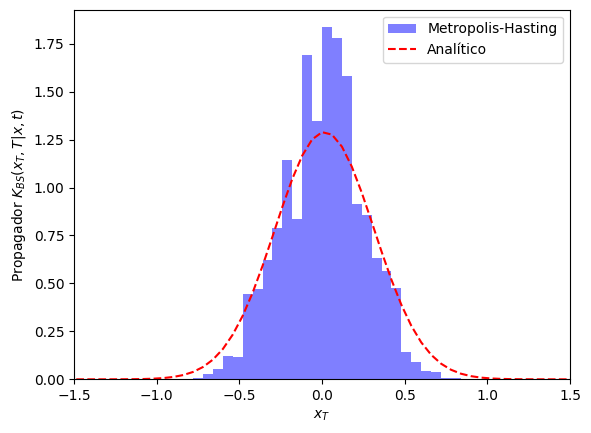

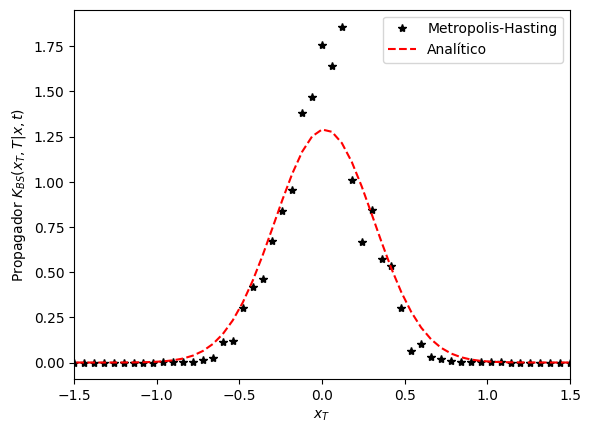

In [5]:
# =====================
# Gráficos comparativos
# =====================

plt.hist(x[-1, :], bins=xx, weights=ExpSBS, color='blue', alpha=0.5, label='Metropolis-Hasting', density=True)
plt.plot(xx, K_BS(xx), 'r--', label='Analítico')
plt.xlabel('$x_T$')
plt.ylabel('Propagador $K_{BS}({x_T,T|x,t})$')
plt.legend()
plt.xlim([-1.5, 1.5])
plt.show()

plt.plot(xx, PathIntegral, 'k*', label='Metropolis-Hasting')
plt.plot(xx, K_BS(xx), 'r--', label='Analítico')
plt.xlabel('$x_T$')
plt.ylabel('Propagador $K_{BS}({x_T,T|x,t})$')
plt.legend()
plt.xlim([-1.5, 1.5])
plt.show()